In [8]:
!pip install transformers
!pip install accelerate
!pip install datasets
!pip install optuna
!pip install onnx
!pip install onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 11.2 MB/s eta 0:00:00


### Making Transformers Efficient in Production

In [15]:
from transformers import pipeline

bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=bert_ckpt)

In [16]:
query = """
Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in
Paris and I need a 15 passenger van
"""
pipe(query)

[{'label': 'car_rental', 'score': 0.5490034222602844}]

### Creating a Performance Benchmark

In [17]:
class PerformanceBenchmark:
    def __init__(self, pipeline, dataset, optim_type="BERT baseline"):
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type

    def compute_accuracy(self):
        # We'll define this later
        pass

    def compute_size(self):
        # We'll define this later
        pass

    def time_pipeline(self):
        # We'll define this later
        pass

    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_accuracy())
        return metrics

In [32]:
from datasets import load_dataset

clinc = load_dataset("clinc_oos", "plus")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for clinc_oos contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/clinc_oos
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [33]:
sample = clinc["test"][42]
sample

{'text': 'transfer $100 from my checking to saving account', 'intent': 133}

In [34]:
intents = clinc["test"].features["intent"]
intents.int2str(sample["intent"])

'transfer'

In [35]:
from datasets import load_metric

accuracy_score = load_metric("accuracy")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [22]:
def compute_accuracy(self):
    """ This overrides the PerformanceBenchmark.compute_accuracy() method """
    preds, labels = [], []
    for example in self.dataset:
        pred = self.pipeline(example["text"])[0]["label"]
        preds.append(intents.str2int(pred))
        label = example["intent"]
        labels.append(label)

    accuracy = accuracy_score.compute(references=labels, predictions=preds)
    print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
    return accuracy

In [23]:
PerformanceBenchmark.compute_accuracy = compute_accuracy

In [24]:
list(pipe.model.state_dict().items())[42]

('bert.encoder.layer.2.attention.self.value.bias',
 tensor([-2.7834e-02,  4.9434e-02,  8.3551e-02,  4.1092e-02,  6.0157e-01,
          1.1774e-01, -5.2112e-02, -6.5143e-02, -2.9358e-02, -4.2250e-02,
          7.9177e-02,  8.0409e-02,  2.9921e-03,  1.7816e-01, -5.0480e-02,
         -1.5634e-01, -2.1707e-02,  1.4381e-02,  2.5132e-02, -2.4110e-02,
         -1.9183e-01, -7.8657e-02,  5.0709e-02,  3.3632e-02, -3.1946e-02,
          1.1616e-01,  9.2720e-02, -1.1787e-01,  2.3233e-01, -1.2678e-02,
         -1.3138e-01, -4.0024e-02,  7.4823e-02, -5.4148e-02, -1.5184e-01,
         -7.4407e-02,  1.1559e-01,  8.2729e-02, -1.3787e-01,  8.3528e-02,
          1.2154e-01,  1.6880e-02, -5.6629e-02, -3.9295e-02,  5.3725e-02,
          6.8602e-02, -1.1294e-01,  4.4001e-02, -2.5884e-01,  1.6767e-01,
          1.8316e-01,  5.6272e-02, -3.6874e-02, -2.7938e-02, -9.3204e-02,
         -7.5239e-03,  4.1141e-02, -1.1542e-02, -9.9749e-02, -3.0910e-02,
          4.1398e-02, -4.4389e-02, -2.6279e-02,  7.2100e-02, 

In [25]:
import torch
from pathlib import Path

def compute_size(self):
    """ This overrides the PerformanceBenchmark.compute_size() method """
    state_dict = self.pipeline.model.state_dict()
    tmp_path = Path("model.pt")
    torch.save(state_dict, tmp_path)

    # Calculate size in megabytes
    size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)

    # Delete temporary file
    tmp_path.unlink()

    print(f"Model size (MB) - {size_mb:.2f}")
    return {"size_mb" : size_mb}

In [26]:
PerformanceBenchmark.compute_size = compute_size

In [27]:
from time import perf_counter

for _ in range(3):
    start_time = perf_counter()
    _ = pipe(query)
    latency = perf_counter() - start_time
    print(f"Latency (ms) - {1000 * latency:.3f}")

Latency (ms) - 137.086
Latency (ms) - 127.624
Latency (ms) - 131.853


In [28]:
import numpy as np

def time_pipeline(self, query="What is the pin number for my account?"):
    """This overrides the PerformanceBenchmark.time_pipeline() method"""
    latencies = []

    # Warmup
    for _ in range(10):
        _ = self.pipeline(query)

    # Timed run
    for _ in range(100):
        start_time = perf_counter()
        _ = self.pipeline(query)
        latency = perf_counter() - start_time
        latencies.append(latency)

    # Compute run statistics
    time_avg_ms = 1000 * np.mean(latencies)
    time_std_ms = 1000 * np.std(latencies)

    print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
    return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

In [29]:
PerformanceBenchmark.time_pipeline = time_pipeline

In [30]:
pb = PerformanceBenchmark(pipe, clinc["test"])
perf_metrics = pb.run_benchmark()

Model size (MB) - 418.15
Average latency (ms) - 213.18 +\- 90.51
Accuracy on test set - 0.867


### Making Models Smaller via Knowledge Distillation

### Creating a Knowledge Distillation Trainer

In [12]:
from transformers import TrainingArguments

class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature


In [13]:
import torch.nn as nn
import torch.nn.functional as F
from transformers import Trainer

class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model

    def compute_loss(self, model, inputs, return_outputs=False):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        inputs = inputs.to(device)
        outputs_stu = model(**inputs)

        # Extract cross-entropy loss and logits from student
        loss_ce = outputs_stu.loss
        logits_stu = outputs_stu.logits

        # Extract logits from teacher
        with torch.no_grad():
            outputs_tea = self.teacher_model(**inputs)
            logits_tea = outputs_tea.logits

        # Soften probabilities and compute distillation loss
        loss_fct = nn.KLDivLoss(reduction="batchmean")
        loss_kd = self.args.temperature ** 2 * loss_fct(
            F.log_softmax(logits_stu / self.args.temperature, dim=-1),
            F.softmax(logits_tea / self.args.temperature, dim=-1))

        # Return weighted student loss
        loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd
        return (loss, outputs_stu) if return_outputs else loss

#### Choosing Good Student Initalization

In [36]:
from transformers import AutoTokenizer

student_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

def tokenize_text(batch):
    return student_tokenizer(batch["text"], truncation=True)

clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=["text"])
clinc_enc = clinc_enc.rename_column("intent", "labels")

In [20]:
from huggingface_hub import notebook_login

notebook_login()

In [21]:
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_score.compute(predictions=predictions, references=labels)

In [22]:
# alpha=1 perform without any signal from the teacher

batch_size = 48

finetuned_ckpt = "distilbert-base-uncased-finetuned-clinc"
student_training_args = DistillationTrainingArguments(output_dir=finetuned_ckpt,
                                                      evaluation_strategy = "epoch",
                                                      num_train_epochs=5,
                                                      learning_rate=2e-5,
                                                      per_device_train_batch_size=batch_size,
                                                      per_device_eval_batch_size=batch_size,
                                                      alpha=1,
                                                      weight_decay=0.01,
                                                      push_to_hub=True)

In [23]:
student_training_args.logging_steps = len(clinc_enc['train']) // batch_size
student_training_args.disable_tqdm = False
student_training_args.save_steps = 1e9
student_training_args.log_level = "passive"

In [24]:
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [25]:
id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id

In [26]:
from transformers import AutoConfig

num_labels = intents.num_classes
student_config = (AutoConfig.from_pretrained(student_ckpt,
                                             num_labels=num_labels,
                                             id2label=id2label,
                                             label2id=label2id))

In [27]:
import torch
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def student_init():
    return (AutoModelForSequenceClassification
            .from_pretrained(student_ckpt, config=student_config).to(device))

In [28]:
teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"

teacher_model = (AutoModelForSequenceClassification
                 .from_pretrained(teacher_ckpt, num_labels=num_labels)
                 .to(device))

In [29]:
distilbert_trainer = DistillationTrainer(model_init=student_init,
                                         teacher_model=teacher_model,
                                         args=student_training_args,
                                         train_dataset=clinc_enc['train'],
                                         eval_dataset=clinc_enc['validation'],
                                         compute_metrics=compute_metrics,
                                         tokenizer=student_tokenizer)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
distilbert_trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,4.301000,3.291063,0.722581
2,2.626000,1.881600,0.840000
3,1.543400,1.160555,0.894194
4,1.007700,0.858913,0.908387
5,0.793800,0.774494,0.916129


TrainOutput(global_step=1590, training_loss=2.0504746542036907, metrics={'train_runtime': 268.2957, 'train_samples_per_second': 284.201, 'train_steps_per_second': 5.926, 'total_flos': 414070678872816.0, 'train_loss': 2.0504746542036907, 'epoch': 5.0})

In [31]:
distilbert_trainer.push_to_hub("Training completed!")

events.out.tfevents.1703757450.5dded002d2ed.21233.0:   0%|          | 0.00/14.5k [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

events.out.tfevents.1703755212.5dded002d2ed.6835.0:   0%|          | 0.00/16.9k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.66k [00:00<?, ?B/s]

'https://huggingface.co/MohamedAhmedAE/distilbert-base-uncased-finetuned-clinc/tree/main/'

In [32]:
finetuned_ckpt = "MohamedAhmedAE/distilbert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=finetuned_ckpt)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [33]:
optim_type = "DistilBERT"
pd = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pd.run_benchmark())

Model size (MB) - 255.88
Average latency (ms) - 63.95 +\- 2.82
Accuracy on test set - 0.855


In [49]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient="index")

    for idx in df.index:
        df_opt = df.loc[idx]

        # Add a dashed circle around the current optimization type
        if idx == current_optim_type:
            plt.scatter(df_opt["time_avg_ms"],
                        df_opt["accuracy"]*100,
                        alpha=0.5,
                        s=df_opt["size_mb"],
                        label=idx,
                        marker="$\u25CC$")
        else:
            plt.scatter(df_opt["time_avg_ms"],
                        df_opt["accuracy"]*100,
                        s=df_opt["size_mb"],
                        label=idx,
                        alpha=0.5)

    legend = plt.legend(bbox_to_anchor=(1,1))
    for handle in legend.legendHandles:
        handle.set_sizes([20])

    plt.ylim(80, 90)

    # Use the slowest model to define the x-axis range
    xlim = int(perf_metrics["BERT baseline"]["time_avg_ms"] + 3)
    plt.xlim(1, xlim)
    plt.xlabel("Average latency (ms)")
    plt.ylabel("Accuracy (%)")
    plt.show()


<ipython-input-34-26ba088b532e>:26: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


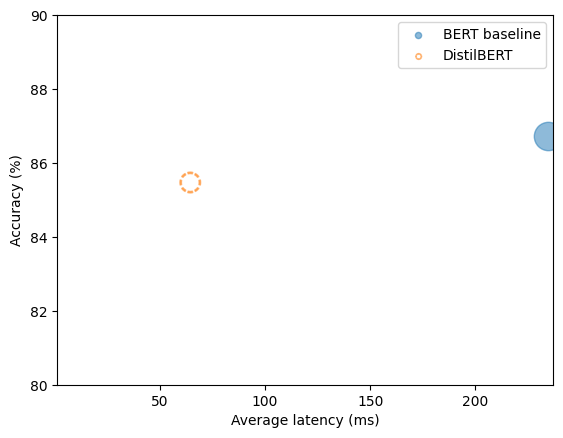

In [35]:
plot_metrics(perf_metrics, optim_type)

### Finding Good Hyperparameters with Optuna

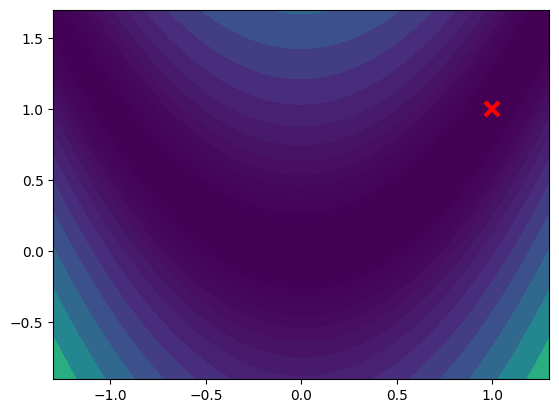

In [36]:
# alt A banana plot
# Caption plot of the rosenbrock function of two variables
# f = (1-x)^2 + 100*(y-x^2)^2

import matplotlib.pyplot as plt
import numpy as np

def f(x, y):
    return (1-x)**2 + 100*(y-x**2)**2

X, Y = np.meshgrid(np.linspace(-2,2,250), np.linspace(-1,3,250))
Z = f(X,Y)

_, ax = plt.subplots()
ax.plot([1], [1], 'x', mew=3, markersize=10, color="red")
ax.contourf(X, Y, Z, np.logspace(-1,3,30), cmap="viridis", extend="both")
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-0.9, 1.7)
plt.show()

In [37]:
def objective(trial):
    x = trial.suggest_float("x", -2, 2)
    y = trial.suggest_float("y", -2, 2)
    return (1-x)**2 + 100*(y-x**2)**2

In [38]:
import optuna

study = optuna.create_study()
study.optimize(objective, n_trials=1000)

[I 2023-12-28 10:11:28,774] A new study created in memory with name: no-name-a8de49f3-07e0-4edf-91d8-1283e55e8d43
[I 2023-12-28 10:11:28,778] Trial 0 finished with value: 711.4000570743377 and parameters: {'x': -1.8027274670606306, 'y': 0.5973844722732373}. Best is trial 0 with value: 711.4000570743377.
[I 2023-12-28 10:11:28,781] Trial 1 finished with value: 954.6395836258866 and parameters: {'x': 1.1603933644590745, 'y': -1.743169840884919}. Best is trial 0 with value: 711.4000570743377.
[I 2023-12-28 10:11:28,786] Trial 2 finished with value: 306.5603189460101 and parameters: {'x': 0.20127716956579356, 'y': 1.789576136441764}. Best is trial 2 with value: 306.5603189460101.
[I 2023-12-28 10:11:28,790] Trial 3 finished with value: 1130.8973169378871 and parameters: {'x': 1.2769923108052823, 'y': -1.7320582367118318}. Best is trial 2 with value: 306.5603189460101.
[I 2023-12-28 10:11:28,793] Trial 4 finished with value: 138.63748112980863 and parameters: {'x': 1.73551945315474, 'y': 1.

In [39]:
study.best_params

{'x': 1.0242399718559985, 'y': 1.0447437404134736}

In [40]:
# trial could suggest int, float, categorical
def hp_space(trial):
    return {"num_train_epochs":trial.suggest_int("num_train_epochs", 5, 10),
            "alpha": trial.suggest_float("alpha", 0, 1),
            "teperature": trial.suggest_int("temperature", 2, 20)}

In [ ]:
best_run = distilbert_trainer.hyperparameter_search(n_trials=20,
                                                    direction="maximize",
                                                    hp_space=hp_space)

[I 2023-12-27 07:49:22,881] A new study created in memory with name: no-name-06eac5b8-fae6-4832-9919-1634e262c231
Trying to set teperature in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.802400,0.410307,0.660000
2,0.307500,0.139704,0.849032
3,0.140500,0.071449,0.896452
4,0.089400,0.052286,0.911290
5,0.070100,0.041902,0.919032
6,0.059800,0.037770,0.924516
7,0.054200,0.034327,0.927097
8,0.050300,0.033076,0.931290
9,0.048000,0.032016,0.929355
10,0.046800,0.031421,0.929355


[I 2023-12-27 07:59:09,408] Trial 0 finished with value: 0.9293548387096774 and parameters: {'num_train_epochs': 10, 'alpha': 0.39314545456735916, 'temperature': 7}. Best is trial 0 with value: 0.9293548387096774.
Trying to set teperature in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.806600,0.420251,0.655484
2,0.321100,0.153053,0.837097
3,0.154300,0.080626,0.888387
4,0.100600,0.059045,0.904516
5,0.080500,0.048803,0.914194
6,0.070600,0.044935,0.918710
7,0.066500,0.043505,0.919032


[I 2023-12-27 08:06:05,931] Trial 1 finished with value: 0.9190322580645162 and parameters: {'num_train_epochs': 7, 'alpha': 0.1629747177287959, 'temperature': 9}. Best is trial 0 with value: 0.9293548387096774.
Trying to set teperature in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.804900,0.416044,0.657097
2,0.315200,0.147219,0.844839
3,0.148100,0.076372,0.892581
4,0.095400,0.055922,0.908065
5,0.075600,0.045460,0.916774
6,0.065300,0.041356,0.920645
7,0.060300,0.038506,0.922581
8,0.057400,0.037959,0.922903


[I 2023-12-27 08:13:51,622] Trial 2 finished with value: 0.9229032258064516 and parameters: {'num_train_epochs': 8, 'alpha': 0.4122688233390891, 'temperature': 7}. Best is trial 0 with value: 0.9293548387096774.
Trying to set teperature in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.803600,0.413000,0.660000
2,0.311000,0.143019,0.847742
3,0.143800,0.073581,0.893871
4,0.092000,0.053796,0.909032
5,0.072400,0.043343,0.919032
6,0.062100,0.039218,0.923226
7,0.056600,0.035928,0.926129
8,0.053000,0.034752,0.928710
9,0.051200,0.034265,0.928710


[I 2023-12-27 08:22:48,689] Trial 3 finished with value: 0.9287096774193548 and parameters: {'num_train_epochs': 9, 'alpha': 0.5310261012587055, 'temperature': 10}. Best is trial 0 with value: 0.9293548387096774.
Trying to set teperature in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.806600,0.420251,0.655484
2,0.321100,0.153053,0.837097
3,0.154300,0.080626,0.888387
4,0.100600,0.059045,0.904516
5,0.080500,0.048803,0.914194
6,0.070600,0.044935,0.918710
7,0.066500,0.043505,0.919032


[I 2023-12-27 08:29:37,484] Trial 4 finished with value: 0.9190322580645162 and parameters: {'num_train_epochs': 7, 'alpha': 0.3924132326347317, 'temperature': 13}. Best is trial 0 with value: 0.9293548387096774.
Trying to set teperature in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.812200,0.434448,0.650323


[I 2023-12-27 08:30:35,152] Trial 5 pruned. 
Trying to set teperature in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.803600,0.413000,0.660000
2,0.311000,0.143019,0.847742
3,0.143800,0.073581,0.893871
4,0.092000,0.053796,0.909032
5,0.072400,0.043343,0.919032
6,0.062100,0.039218,0.923226
7,0.056600,0.035928,0.926129
8,0.053000,0.034752,0.928710
9,0.051200,0.034265,0.928710


[I 2023-12-27 08:39:00,959] Trial 6 pruned. 
Trying to set teperature in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.804900,0.416044,0.657097
2,0.315200,0.147219,0.844839
3,0.148100,0.076372,0.892581
4,0.095400,0.055922,0.908065
5,0.075600,0.045460,0.916774
6,0.065300,0.041356,0.920645
7,0.060300,0.038506,0.922581
8,0.057400,0.037959,0.922903


[I 2023-12-27 08:46:30,634] Trial 7 pruned. 
Trying to set teperature in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.802400,0.410307,0.660000
2,0.307500,0.139704,0.849032
3,0.140500,0.071449,0.896452
4,0.089400,0.052286,0.911290
5,0.070100,0.041902,0.919032
6,0.059800,0.037770,0.924516
7,0.054200,0.034327,0.927097
8,0.050300,0.033076,0.931290
9,0.048000,0.032016,0.929355
10,0.046800,0.031421,0.929355


[I 2023-12-27 08:55:51,251] Trial 8 finished with value: 0.9293548387096774 and parameters: {'num_train_epochs': 10, 'alpha': 0.30573790249861654, 'temperature': 11}. Best is trial 0 with value: 0.9293548387096774.
Trying to set teperature in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.802400,0.410307,0.660000
2,0.307500,0.139704,0.849032
3,0.140500,0.071449,0.896452
4,0.089400,0.052286,0.911290
5,0.070100,0.041902,0.919032
6,0.059800,0.037770,0.924516
7,0.054200,0.034327,0.927097
8,0.050300,0.033076,0.931290
9,0.048000,0.032016,0.929355
10,0.046800,0.031421,0.929355


[I 2023-12-27 09:05:12,461] Trial 9 finished with value: 0.9293548387096774 and parameters: {'num_train_epochs': 10, 'alpha': 0.3967069119060189, 'temperature': 19}. Best is trial 0 with value: 0.9293548387096774.
Trying to set teperature in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.812200,0.434448,0.650323


[I 2023-12-27 09:06:09,771] Trial 10 pruned. 
Trying to set teperature in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.802400,0.410307,0.660000
2,0.307500,0.139704,0.849032
3,0.140500,0.071449,0.896452
4,0.089400,0.052286,0.911290
5,0.070100,0.041902,0.919032
6,0.059800,0.037770,0.924516
7,0.054200,0.034327,0.927097
8,0.050300,0.033076,0.931290
9,0.048000,0.032016,0.929355
10,0.046800,0.031421,0.929355


[I 2023-12-27 09:15:32,516] Trial 11 finished with value: 0.9293548387096774 and parameters: {'num_train_epochs': 10, 'alpha': 0.24374958968780763, 'temperature': 6}. Best is trial 0 with value: 0.9293548387096774.
Trying to set teperature in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.802400,0.410307,0.660000
2,0.307500,0.139704,0.849032
3,0.140500,0.071449,0.896452
4,0.089400,0.052286,0.911290
5,0.070100,0.041902,0.919032
6,0.059800,0.037770,0.924516
7,0.054200,0.034327,0.927097
8,0.050300,0.033076,0.931290
9,0.048000,0.032016,0.929355
10,0.046800,0.031421,0.929355


[I 2023-12-27 09:24:54,393] Trial 12 finished with value: 0.9293548387096774 and parameters: {'num_train_epochs': 10, 'alpha': 0.03180061883290952, 'temperature': 16}. Best is trial 0 with value: 0.9293548387096774.
Trying to set teperature in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.803600,0.413000,0.660000
2,0.311000,0.143019,0.847742


[I 2023-12-27 09:26:48,041] Trial 13 pruned. 
Trying to set teperature in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.802400,0.410307,0.660000
2,0.307500,0.139704,0.849032
3,0.140500,0.071449,0.896452
4,0.089400,0.052286,0.911290
5,0.070100,0.041902,0.919032
6,0.059800,0.037770,0.924516
7,0.054200,0.034327,0.927097
8,0.050300,0.033076,0.931290
9,0.048000,0.032016,0.929355
10,0.046800,0.031421,0.929355


[I 2023-12-27 09:36:09,700] Trial 14 finished with value: 0.9293548387096774 and parameters: {'num_train_epochs': 10, 'alpha': 0.7191943932668754, 'temperature': 15}. Best is trial 0 with value: 0.9293548387096774.
Trying to set teperature in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.809100,0.426365,0.653226


[I 2023-12-27 09:37:06,895] Trial 15 pruned. 
Trying to set teperature in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.803600,0.413000,0.660000
2,0.311000,0.143019,0.847742


[I 2023-12-27 09:39:00,517] Trial 16 pruned. 
Trying to set teperature in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.804900,0.416044,0.657097


[I 2023-12-27 09:39:57,813] Trial 17 pruned. 
Trying to set teperature in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.802400,0.410307,0.660000
2,0.307500,0.139704,0.849032
3,0.140500,0.071449,0.896452
4,0.089400,0.052286,0.911290
5,0.070100,0.041902,0.919032
6,0.059800,0.037770,0.924516
7,0.054200,0.034327,0.927097
8,0.050300,0.033076,0.931290
9,0.048000,0.032016,0.929355
10,0.046800,0.031421,0.929355


[I 2023-12-27 09:49:19,997] Trial 18 finished with value: 0.9293548387096774 and parameters: {'num_train_epochs': 10, 'alpha': 0.6004394403545945, 'temperature': 20}. Best is trial 0 with value: 0.9293548387096774.
Trying to set teperature in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.803600,0.413000,0.660000
2,0.311000,0.143019,0.847742


[I 2023-12-27 09:51:13,080] Trial 19 pruned. 


In [ ]:
# print(best_run)

BestRun(run_id='0', objective=0.9293548387096774, hyperparameters={'num_train_epochs': 10, 'alpha': 0.39314545456735916, 'temperature': 7}, run_summary=None)


In [ ]:
# for k, v in best_run.hyperparameters.items():
#     setattr(student_training_args, k, v)

In [41]:
hyperparameters={'num_train_epochs': 10,
                 'alpha': 0.39314545456735916,
                 'temperature': 7}

for k, v in hyperparameters.items():
    setattr(student_training_args, k, v)

In [42]:
# Define a new repository to store our distilled model
distilled_ckpt = "distilbert-base-uncased-distilled-clinc"
student_training_args.output_dir = distilled_ckpt

# Create a new Trainer with optimal parameters
distil_trainer = DistillationTrainer(model_init=student_init,
                                     teacher_model=teacher_model,
                                     args=student_training_args,
                                     train_dataset=clinc_enc['train'],
                                     eval_dataset=clinc_enc['validation'],
                                     compute_metrics=compute_metrics,
                                     tokenizer=student_tokenizer)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.

In [43]:
distil_trainer.train()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.

Epoch,Training Loss,Validation Loss,Accuracy
1,1.946000,1.403682,0.749032
2,1.093200,0.741857,0.881935
3,0.596400,0.427501,0.924194
4,0.354800,0.295513,0.932903
5,0.245100,0.238207,0.940968
6,0.193700,0.213055,0.945806
7,0.168100,0.202137,0.946774
8,0.154300,0.197510,0.946452
9,0.145800,0.192999,0.946774
10,0.141900,0.191305,0.947097


TrainOutput(global_step=3180, training_loss=0.5027856031303886, metrics={'train_runtime': 548.7739, 'train_samples_per_second': 277.892, 'train_steps_per_second': 5.795, 'total_flos': 826606671183048.0, 'train_loss': 0.5027856031303886, 'epoch': 10.0})

In [44]:
distil_trainer.push_to_hub("Training complete")

training_args.bin:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

'https://huggingface.co/MohamedAhmedAE/distilbert-base-uncased-distilled-clinc/tree/main/'

### Benchmarking our distilled model

In [45]:
distilled_ckpt = "MohamedAhmedAE/distilbert-base-uncased-distilled-clinc"
pipe = pipeline("text-classification", model=distilled_ckpt)
optim_type = "Distillation"
pd = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 418.15
Average latency (ms) - 133.58 +\- 14.21
Accuracy on test set - 0.867


In [46]:
perf_metrics

{'BERT baseline': {'size_mb': 418.1471004486084,
  'time_avg_ms': 133.58108917997924,
  'time_std_ms': 14.21146364357516,
  'accuracy': 0.8672727272727273},
 'DistilBERT': {'size_mb': 255.88184547424316,
  'time_avg_ms': 63.94904449994102,
  'time_std_ms': 2.824106684271823,
  'accuracy': 0.854909090909091}}

<ipython-input-48-26ba088b532e>:26: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


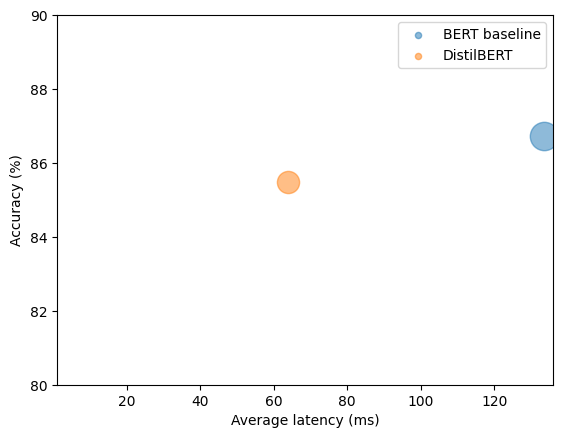

In [49]:
plot_metrics(perf_metrics, optim_type)

### Making Models Faster With Quantization

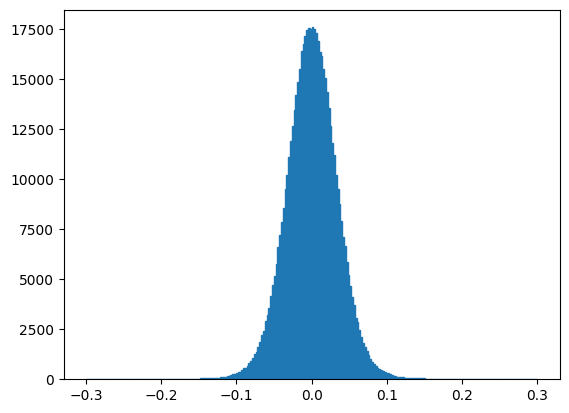

In [50]:
import matplotlib.pyplot as plt

state_dict = pipe.model.state_dict()
weights = state_dict["distilbert.transformer.layer.0.attention.out_lin.weight"]
plt.hist(weights.flatten().numpy(), bins=250, range=(-0.3, 0.3), edgecolor="C0")
plt.show()

In [51]:
zero_point = 0

# int8 from -128 - 127
scale = (weights.max() - weights.min()) / (127 - (-128))

In [52]:
(weights / scale + zero_point).clamp(-128, 127).round().char()

tensor([[ -6,  -7,   0,  ...,  -6,  -4,   8],
        [  9,   3,   1,  ...,  -4,   7,   0],
        [ -9,  -5,   5,  ...,   1,   6,  -3],
        ...,
        [  5,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1, -10,  ...,   8,   2,  -2]], dtype=torch.int8)

In [53]:
from torch import quantize_per_tensor

dtype = torch.qint8
quantized_weights = quantize_per_tensor(weights, scale, zero_point, dtype)
quantized_weights.int_repr()

tensor([[ -6,  -7,   0,  ...,  -6,  -4,   8],
        [  9,   3,   1,  ...,  -4,   7,   0],
        [ -9,  -5,   5,  ...,   1,   6,  -3],
        ...,
        [  5,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1, -10,  ...,   8,   2,  -2]], dtype=torch.int8)

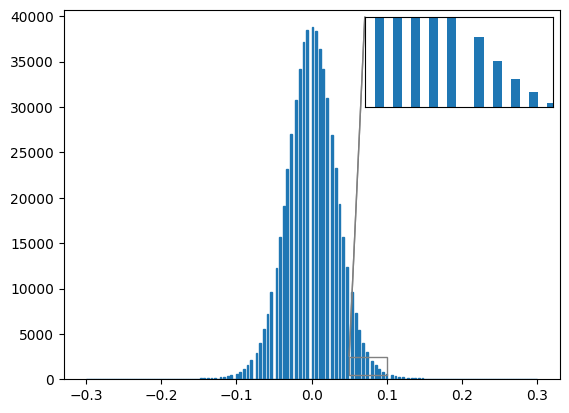

In [54]:
# alt Effect of quantization on transformer's weights
# caption Effect of quantization on transformer's weights
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

# Create histogram
fig, ax = plt.subplots()
ax.hist(quantized_weights.dequantize().flatten().numpy(),
        bins=250,
        range=(-0.3, 0.3),
        edgecolor="C0")

# Create zoom inset
axins = zoomed_inset_axes(ax, 5, loc="upper right")
axins.hist(quantized_weights.dequantize().flatten().numpy(),
           bins=250,
           range=(-0.3, 0.3))

x1, x2, y1, y2 = 0.05, 0.1, 500, 2500
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.axes.xaxis.set_visible(False)
axins.axes.yaxis.set_visible(False)
mark_inset(ax, axins, loc1=2, loc2=2, fc="none", ec="0.5")
plt.show()

In [55]:
from torch import quantize_per_tensor

dtype = torch.qint8
quantized_weights = quantize_per_tensor(weights, scale, zero_point, dtype)
quantized_weights.int_repr()

tensor([[ -6,  -7,   0,  ...,  -6,  -4,   8],
        [  9,   3,   1,  ...,  -4,   7,   0],
        [ -9,  -5,   5,  ...,   1,   6,  -3],
        ...,
        [  5,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1, -10,  ...,   8,   2,  -2]], dtype=torch.int8)

In [56]:
%%timeit

weights @ weights

10.2 ms ± 1.74 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [57]:
from torch.nn.quantized import QFunctional

q_fn = QFunctional()

In [58]:
%%timeit

q_fn.mul(quantized_weights, quantized_weights)

265 µs ± 5.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [59]:
import sys

sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())

<ipython-input-59-600687c2638a>:3: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())


3.999755879241598

In [60]:
from torch.quantization  import quantize_dynamic

### This could work with this size on mobile and embedding device

model_ckpt = "MohamedAhmedAE/distilbert-base-uncased-distilled-clinc"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt).to("cpu"))
model_quantized = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

### Benchmarking Our Quantized Model

In [61]:
pipe = pipeline("text-classification", model=model_quantized,
                tokenizer=tokenizer)
optim_type = "Distillation + quantization"
pd = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pd.run_benchmark())

Model size (MB) - 132.39
Average latency (ms) - 20.35 +\- 3.72
Accuracy on test set - 0.879


<ipython-input-63-26ba088b532e>:26: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


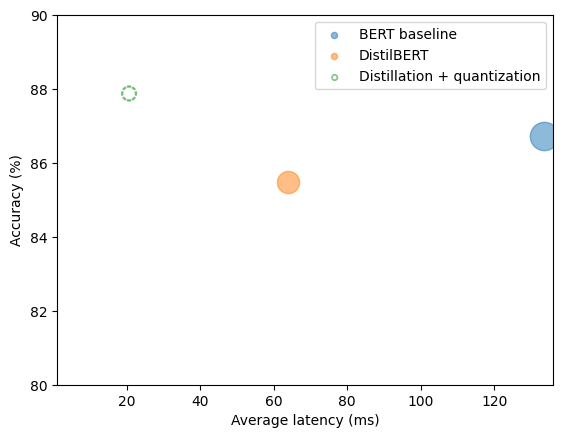

In [64]:
plot_metrics(perf_metrics, optim_type)

### Optimizing Inference with ONNX and the ONNX Runtime

In [2]:
import os
from psutil import cpu_count

os.environ["OMP_NUM_THREADS"] = f"{cpu_count()}"
os.environ["OMP_WAIT_POLICY"] = "ACTIVE"

In [3]:
from transformers import AutoTokenizer

model_ckpt = "MohamedAhmedAE/distilbert-base-uncased-distilled-clinc"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [5]:
from transformers.convert_graph_to_onnx import convert
from pathlib import Path

model_ckpt = "MohamedAhmedAE/distilbert-base-uncased-distilled-clinc"
onnx_model_path = Path("onnx/model.onnx")
convert(framework="pt",
        model=model_ckpt,
        tokenizer=tokenizer,
        output=onnx_model_path,
        opset=12,
        pipeline_name="text-classification")

/usr/local/lib/python3.10/dist-packages/transformers/convert_graph_to_onnx.py:379: FutureWarning: The `transformers.convert_graph_to_onnx` package is deprecated and will be removed in version 5 of Transformers
  warnings.warn(


ONNX opset version set to: 12
Loading pipeline (model: MohamedAhmedAE/distilbert-base-uncased-distilled-clinc, tokenizer: DistilBertTokenizerFast(name_or_path='MohamedAhmedAE/distilbert-base-uncased-distilled-clinc', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=Fals

/usr/local/lib/python3.10/dist-packages/transformers/models/distilbert/modeling_distilbert.py:223: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  mask, torch.tensor(torch.finfo(scores.dtype).min)


In [9]:
from onnxruntime import (GraphOptimizationLevel, InferenceSession,
                         SessionOptions)

def create_model_for_provider(model_path, provider="CPUExecutionProvider"):
    options = SessionOptions()
    options.intra_op_num_threads = 1
    options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL
    session = InferenceSession(str(model_path), options, providers=[provider])
    session.disable_fallback()
    return session

In [10]:
onnx_model = create_model_for_provider(onnx_model_path)

In [37]:
inputs = clinc_enc["test"][:1]
del inputs["labels"]
logits_onnx = onnx_model.run(None, inputs)[0]
logits_onnx.shape

(1, 151)

In [38]:
import numpy as np

np.argmax(logits_onnx)

61

In [39]:
clinc_enc["test"][0]["labels"]

61

In [40]:
from scipy.special import softmax

class OnnxPipeline:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def __call__(self, query):
        model_inputs = self.tokenizer(query, return_tensors="pt")
        inputs_onnx = {k: v.cpu().detach().numpy()
                       for k, v in model_inputs.items()}
        logits = self.model.run(None, inputs_onnx)[0][0, :]
        probs = softmax(logits)
        pred_idx = np.argmax(probs).item()
        return [{"label": intents.int2str(pred_idx),
                 "score": probs[pred_idx]}]

In [41]:
pipe = OnnxPipeline(onnx_model, tokenizer)
pipe(query)

[{'label': 'car_rental', 'score': 0.92241347}]

In [42]:
class OnnxPerformanceBenchmark(PerformanceBenchmark):
    def __init__(self, *args, model_path, **kwargs):
        super().__init__(*args, **kwargs)
        self.model_path = model_path

    def compute_size(self):
        size_mb = Path(self.model_path).stat().st_size / (1024 * 1024)
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

In [43]:
optim_type = "Distillation + ORT"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type,
                              model_path="onnx/model.onnx")

### Addd Quantization to ONNX

In [44]:
from onnxruntime.quantization import quantize_dynamic, QuantType

model_input = "onnx/model.onnx"
model_output = "onnx/model.quant.onnx"
quantize_dynamic(model_input, model_output, weight_type=QuantType.QInt8)

Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.0/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.0/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.1/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.1/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.2/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.2/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.3/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.3/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.4/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.4/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.5/attention/MatMul]
Ignore MatM

In [47]:
onnx_quantized_model = create_model_for_provider(model_output)
pipe = OnnxPipeline(onnx_quantized_model, tokenizer)
optim_type = "Disillation + ORT (Quantized)"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type,
                              model_path=model_output)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 64.36
Average latency (ms) - 21.49 +\- 8.18
Accuracy on test set - 0.883


<ipython-input-49-26ba088b532e>:26: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


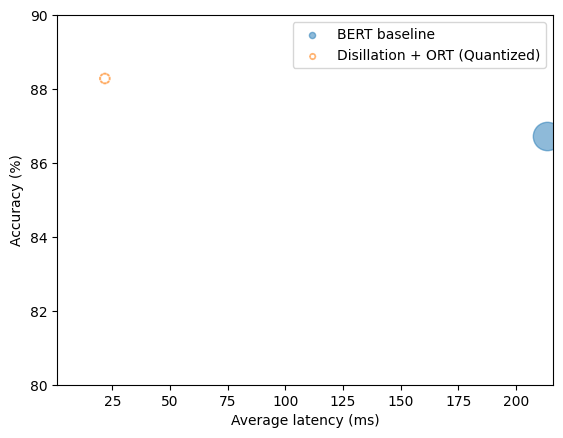

In [50]:
plot_metrics(perf_metrics, optim_type)

### Sparsity in Deep Neural Networks

#### Weight Pruning Methods

##### Magnitude puring

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def _sparsity(t, t_0=1, dt=1, s_i=0, s_f=0.9, N=100):
    return s_f + (s_i - s_f) * (1 - (t - t_0) / (N * dt))**3

steps = np.linspace(0, 100, 100)
values = [_sparsity(t) for t in steps]

fig, ax = plt.subplots()
ax.plot(steps, values)
ax.set_ylim(0, 1)
ax.set_ylabel("Sparsity")
ax.set_xlim(0, 100)
ax.set_xlabel("Pruning step")
plt.grid(linestyle="dashed")
plt.show()